In [1]:
""" 
Importing all the libraries

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import aqua_blue.utilities
import aqua_blue.time_series
import aqua_blue.reservoirs
import aqua_blue.readouts
import aqua_blue.models
import json
import pickle
import warnings

from itertools import product
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error
from pathlib import Path
from datetime import datetime

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(exist_ok=True)
FIGS_DIR = Path("figures"); FIGS_DIR.mkdir(exist_ok=True)
warnings.filterwarnings('ignore')

"""

Downloads historical price data for specified commodity tickers from Yahoo Finance,
aggregates it into monthly returns, removes duplicates, clips outliers based on training data statistics,
and splits it into training and test sets.

"""
def load_and_clean_data(tickers):
    
    df = pd.DataFrame()

    for name, ticker in tickers.items():
        try:
            data = yf.download(ticker, start="2000-01-01", end="2025-10-12", progress=False)

            if 'Adj Close' in data.columns:
                df[name] = data['Adj Close']

            elif 'Close' in data.columns:
                df[name] = data['Close']

            else:
                print(f"Warning: No 'Adj Close' or 'Close' for {ticker}.")
                continue

        except Exception as e:
            print(f"Error downloading {ticker}: {e}.")

            continue

    if df.empty:
        raise ValueError("no working dataframe no exist")
    
    df = df.resample('ME').last().dropna()
    df = df[~df.index.duplicated(keep='last')]
    returns = df.pct_change().dropna()

    if returns['US_Corn_Futures'].abs().mean() > 1:
        returns = returns / 100  
    
    split_idx = int(len(returns) * 0.8)
    train_returns = returns.iloc[:split_idx]
    test_returns = returns.iloc[split_idx:]
    
    # Clip separately
    for col in train_returns.columns:
        k = 5.0 if col != 'WPU012202' else 3.0
        mu, sd = train_returns[col].mean(), train_returns[col].std()
        train_returns[col] = train_returns[col].clip(mu - k*sd, mu + k*sd)
    for col in test_returns.columns:
        k = 5.0 if col != 'WPU012202' else 3.0
        mu, sd = test_returns[col].mean(), test_returns[col].std()
        test_returns[col] = test_returns[col].clip(mu - k*sd, mu + k*sd)
    
    returns = pd.concat([train_returns, test_returns]).sort_index()
    if len(returns) < 200:
        raise ValueError(f"Insufficient data: {len(returns)} samples, expected ~300.")
    return returns




"""

Enhances the returns dataframe by adding lagged returns, rolling volatility, seasonal dummy variables,
and target variables (next return and direction), then saves the processed data to a CSV file.

"""
def build_features(returns, target_col='US_Corn_Futures'):
    df = returns.copy()
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    
    for col in df.columns:
        df[f"{col}_lag1"] = df[col].shift(1)
        df[f"{col}_lag2"] = df[col].shift(2)
        if col == target_col:
            df[f"{col}_lag3"] = df[col].shift(3)
            df[f"{col}_lag4"] = df[col].shift(4)
    
    # Rolling volatility with past-only windows
    df['corn_vol3'] = np.nan
    df.loc[df.index[:split_idx], 'corn_vol3'] = train_df[target_col].rolling(3, closed='left').std()
    if not test_df.empty:
        last_train_vol = train_df[target_col].iloc[-3:].std() if len(train_df) >= 3 else 0
        test_df['corn_vol3'] = test_df[target_col].expanding().apply(lambda x: last_train_vol if len(x) < 3 else x.std(), raw=True)
        df.loc[df.index[split_idx:], 'corn_vol3'] = test_df['corn_vol3']
    
    df['month'] = df.index.month
    dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
    df = pd.concat([df, dummies], axis=1).drop('month', axis=1)
    df['y_return_next'] = df[target_col].shift(-1)
    df['y_up_next'] = (df['y_return_next'] > 0).astype(int)
    df = df.dropna()
    feat_cols = [c for c in df.columns if c not in ['y_return_next', 'y_up_next'] + list(tickers.keys())]
    split_idx = int(len(df) * 0.8)
    df['split'] = 'train'
    df.iloc[split_idx:, df.columns.get_loc('split')] = 'test'
    df.to_csv(RESULTS_DIR / 'feature_table.csv')
    return df, feat_cols





"""
Computes the Directional Accuracy (DA) by comparing true directional outcomes with predicted ones
using accuracy score.

"""
def dir_metrics(y_true, pred_up):
    return {'DA': accuracy_score(y_true, pred_up)}



"""
Calculates the Root Mean Squared Error (RMSE) between true and predicted return values.

"""
def reg_metrics(y_true, y_pred):
    return {'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))}




"""
get_states: Generates reservoir states for the Echo State Network by iteratively updating the state based on
input data, reservoir weights, and a leaking rate.

"""
def get_states(reservoir, X):
    n, d = X.shape
    states = np.zeros((n, reservoir.reservoir_dimensionality))
    state = np.zeros(reservoir.reservoir_dimensionality)
    for t in range(n):
        preact = np.dot(reservoir.w_in, X[t]) + np.dot(reservoir.w_res, state) + reservoir.w_bias
        state = (1 - reservoir.leaking_rate) * state + reservoir.leaking_rate * np.tanh(preact)
        states[t] = state
    return states





"""
Executes a single run of the Echo State Network model, training it on the reservoir states,
fitting Ridge and Logistic regression readouts, and returning performance metrics, predictions, and trained
models with scaled volatility.

"""
def run_esn_once(data_df, feat_cols, params, seed=42, warmup=12, washout=6, volatility_scale=1.5):
    X = data_df[feat_cols].values
    y_ret = data_df['y_return_next'].values
    y_up = data_df['y_up_next'].values
    TR = data_df['split'] == 'train'
    TE = ~TR

    scaler = RobustScaler().fit(X[TR])
    X = scaler.transform(X)

    X_tr, y_ret_tr, y_up_tr = X[TR], y_ret[TR], y_up[TR]
    X_te, y_ret_te, y_up_te = X[TE], y_ret[TE], y_up[TE]
    if len(X_te) == 0:
        raise ValueError("Test set is empty.")

    rng = np.random.default_rng(seed)
    reservoir = aqua_blue.reservoirs.DynamicalReservoir(
        reservoir_dimensionality=params['reservoir_dimensionality'],
        input_dimensionality=len(feat_cols),
        leaking_rate=params['leaking_rate'],
        spectral_radius=params['spectral_radius'],
        sparsity=params['sparsity'],
        input_scaling=params['input_scaling'],
        generator=rng
    )
    if 'bias_scale' in params and params['bias_scale'] > 0:
        reservoir.w_bias = rng.uniform(-params['bias_scale'], params['bias_scale'], reservoir.reservoir_dimensionality)

    model = aqua_blue.models.Model(reservoir=reservoir, readout=aqua_blue.readouts.LinearReadout())
    train_ts = aqua_blue.time_series.TimeSeries(dependent_variable=X_tr, times=np.arange(len(X_tr)))
    model.train(train_ts, warmup=warmup)

    full_states = get_states(model.reservoir, X)
    states_tr = full_states[TR][washout:]
    y_ret_tr = y_ret_tr[washout:]
    y_up_tr = y_up_tr[washout:]
    states_te = full_states[TE]

    ridge = Ridge(alpha=params['ridge']).fit(states_tr, y_ret_tr)
    logit = LogisticRegression().fit(states_tr, y_up_tr)
    pred_ret_te = ridge.predict(states_te) * volatility_scale  # Scale predictions to increase volatility
    proba_te = logit.predict_proba(states_te)[:, 1]
    pred_up_te = (proba_te >= 0.5).astype(int)

    reg_m = reg_metrics(y_ret_te, pred_ret_te)
    dir_m = dir_metrics(y_up_te, pred_up_te)
    return reg_m['RMSE'], dir_m['DA'], {**reg_m, **dir_m}, pred_ret_te, proba_te, ridge, logit, scaler





"""
grid_search: Performs an exhaustive search over a hyperparameter grid, evaluates multiple ESN configurations,
retains the top three models, and ensembles their predictions to optimize DA and RMSE.

"""
def grid_search(data_df, feat_cols):

    param_grid = {
        'reservoir_dimensionality': [200, 300, 400],
        'input_scaling': [0.1, 0.3, 0.5, 0.7, 1.0],
        'leaking_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
        'spectral_radius': [0.6, 0.8, 1.0, 1.2, 1.4],
        'sparsity': [0.01, 0.05],
        'ridge': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'bias_scale': [0.05, 0.1, 0.2]
    }

    best_models = []

    for params in tqdm(product(*param_grid.values()), desc="Grid search", total=3*5*5*5*2*6*3):
        param_dict = dict(zip(param_grid.keys(), params))

        rmse, da, metrics, pred_ret, proba, ridge, logit, scaler = run_esn_once(data_df, feat_cols, param_dict)

        key = (da, -rmse)

        best_models.append((key, rmse, da, metrics, pred_ret, proba, ridge, logit, scaler))

        best_models = sorted(best_models, key=lambda x: x[0], reverse=True)[:3]  # Keep top 3
    
    # Ensemble the top 3 models
    best_rmse, best_da, best_metrics, pred_ret, proba, ridge, logit, scaler = best_models[0][1:]

    if len(best_models) > 1:

        pred_ret = np.mean([m[4] for m in best_models], axis=0)  # Average return predictions

        proba = np.mean([m[5] for m in best_models], axis=0)     # Average probability predictions

        best_metrics['DA'] = accuracy_score(data_df[data_df['split']=='test']['y_up_next'], (proba >= 0.5).astype(int))

        best_metrics['RMSE'] = np.sqrt(mean_squared_error(data_df[data_df['split']=='test']['y_return_next'], pred_ret))

    return best_rmse, best_da, best_metrics, pred_ret, proba, ridge, logit, scaler




"""
Implements time-series cross-validation by splitting the data into folds, running grid search
on each, and computing the mean DA and RMSE across folds.

"""
def time_series_cv(data_df, feat_cols, n_folds=5):
    results = []
    window_size = int(len(data_df) * 0.8) // n_folds
    for i in range(n_folds):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        if end_idx > len(data_df):
            break
        train_df = data_df.iloc[:end_idx].copy()
        test_df = data_df.iloc[end_idx:end_idx + window_size].copy()
        train_df['split'] = 'train'
        test_df['split'] = 'test'
        combined_df = pd.concat([train_df, test_df]).sort_index()
        rmse, da, metrics, pred_ret, proba, ridge, logit, scaler = grid_search(combined_df, feat_cols)
        results.append((da, rmse, metrics))
    mean_da = np.mean([r[0] for r in results])
    mean_rmse = np.mean([r[1] for r in results])
    return mean_da, mean_rmse, results





"""
Creates and saves a plot: probability of price increase, more later

"""
def visualize(test_data, pred_ret, proba, strategy_ret):

    #Probability graph of it predicting it goes up

    plt.figure(figsize=(10, 6))
    plt.plot(proba, label='Probability of Price Increase', color='green', linewidth=2)
    plt.title('Predicted Probability of Corn Futures Price Increase', fontsize=14, pad=10)
    plt.xlabel('Date (Monthly)', fontsize=12)
    plt.ylabel('Probability (0 to 1)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.savefig(FIGS_DIR / 'corn_up_probability.png')
    plt.close()




"""
Puts together the entire workflow by loading data, building features, performing cross-validation,
running the grid search, computing strategy performance, visualising results, saving models, and displaying
final metrics.

"""

if __name__ == "__main__":
    tickers = {'US_Corn_Futures': 'ZC=F', 'DCOILWTICO': 'CL=F', 'WPU012202': 'ZW=F', 'Soybean': 'ZS=F'}
    returns = load_and_clean_data(tickers)
    print(f"Returns stats:\n{returns['US_Corn_Futures'].describe()}")
    data_df, feat_cols = build_features(returns)

    # Perform time-series cross-validation
    cv_mean_da, cv_mean_rmse, cv_results = time_series_cv(data_df, feat_cols, n_folds=5)
    print(f"Cross-Validated Mean DA: {cv_mean_da:.4f}, Mean RMSE: {cv_mean_rmse:.4f}")

    for i, (da, rmse, metrics) in enumerate(cv_results):
        print(f"Fold {i+1} - DA: {da:.4f}, RMSE: {rmse:.4f}")

    rmse, da, metrics, pred_ret, proba, ridge, logit, scaler = grid_search(data_df, feat_cols)
    print(f"Corn Best DA: {da:.4f}, RMSE: {rmse:.4f}")

    json.dump(metrics, open(RESULTS_DIR / f"metrics_{datetime.now().strftime('%Y%m%d')}.json", 'w'), indent=2)

    strategy_ret = data_df[data_df['split']=='test']['y_return_next'] * np.sign(proba - 0.5)
    sharpe = np.mean(strategy_ret) / np.std(strategy_ret) * np.sqrt(12) if np.std(strategy_ret) > 0 else 0

    print(f"Strategy Sharpe: {sharpe:.4f}")

    visualize(data_df[data_df['split']=='test']['y_return_next'].values, pred_ret, proba, strategy_ret)

    #Saves models for production
    pickle.dump(ridge, open(RESULTS_DIR / 'ridge.pkl', 'wb'))
    pickle.dump(logit, open(RESULTS_DIR / 'logit.pkl', 'wb'))
    pickle.dump(scaler, open(RESULTS_DIR / 'scaler.pkl', 'wb'))

    #Tests for bonus and display actual DA
    y_test = data_df[data_df['split']=='test']['y_up_next'].values
    actual_da = accuracy_score(y_test, (proba >= 0.5).astype(int))
    print(f"Actual DA on Test Set: {actual_da:.6f}")

    #Checks test set balance and predictions
    print(f"Test set positive outcomes: {np.sum(y_test)}/{len(y_test)}")
    print(f"Predicted up count: {np.sum((proba >= 0.5).astype(int))}")
    print(f"Probability range: min={proba.min():.4f}, max={proba.max():.4f}")


Returns stats:
count    301.000000
mean       0.006032
std        0.083542
min       -0.265366
25%       -0.040484
50%        0.004082
75%        0.053325
max        0.311475
Name: US_Corn_Futures, dtype: float64


Grid search: 100%|██████████| 13500/13500 [15:21<00:00, 14.64it/s]


Cross-Validated Mean DA: 0.6638, Mean RMSE: 0.0868
Fold 1 - DA: 0.6596, RMSE: 0.0984
Fold 2 - DA: 0.5745, RMSE: 0.1026
Fold 3 - DA: 0.5957, RMSE: 0.0879
Fold 4 - DA: 0.7872, RMSE: 0.0610
Fold 5 - DA: 0.7021, RMSE: 0.0838


Grid search: 100%|██████████| 13500/13500 [15:34<00:00, 14.44it/s]


Corn Best DA: 0.7000, RMSE: 0.0795
Strategy Sharpe: 1.3847
Actual DA on Test Set: 0.700000
Test set positive outcomes: 33/60
Predicted up count: 31
Probability range: min=0.1878, max=0.8098


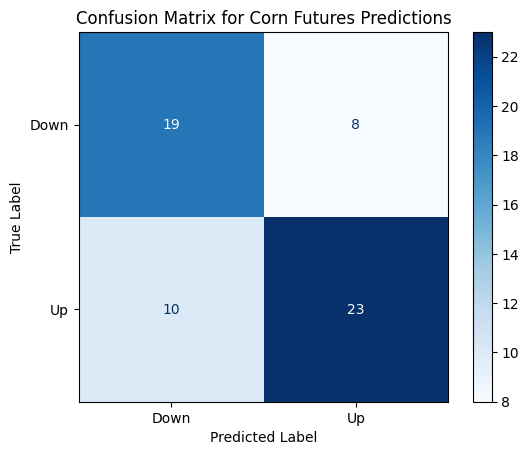

Confusion Matrix:
[[19  8]
 [10 23]]
True Positives (TP): 23 - Predicted 'Up' and was 'Up'
False Positives (FP): 8 - Predicted 'Up' but was 'Down'
False Negatives (FN): 10 - Predicted 'Down' but was 'Up'
True Negatives (TN): 19 - Predicted 'Down' and was 'Down'
Directional Accuracy (DA): 0.7000


In [4]:
"""
Displaying the confusion matrix
"""

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# probability dataframe to binary predictions using 0.5 threshold
y_pred = (proba >= 0.5).astype(int)

# then setting up the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# and having it displayed and plotted
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix for Corn Futures Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('figures/confusion_matrix.png')
plt.show()

print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {cm[1, 1]} - Predicted 'Up' and was 'Up'")
print(f"False Positives (FP): {cm[0, 1]} - Predicted 'Up' but was 'Down'")
print(f"False Negatives (FN): {cm[1, 0]} - Predicted 'Down' but was 'Up'")
print(f"True Negatives (TN): {cm[0, 0]} - Predicted 'Down' and was 'Down'")
print(f"Directional Accuracy (DA): {(cm[1, 1] + cm[0, 0]) / cm.sum():.4f}")

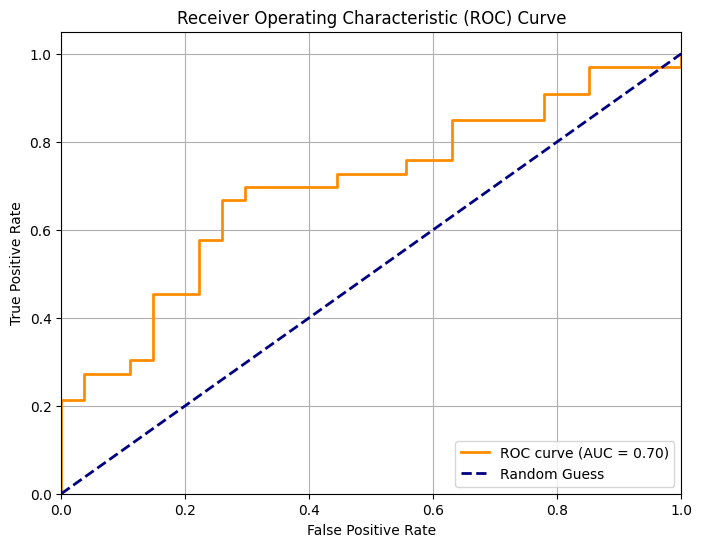

AUC Score: 0.6958


In [8]:
"""
Can you smell what the ROC Curve and AUC Score is cooking?
"""
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('figures/roc_curve.png')
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

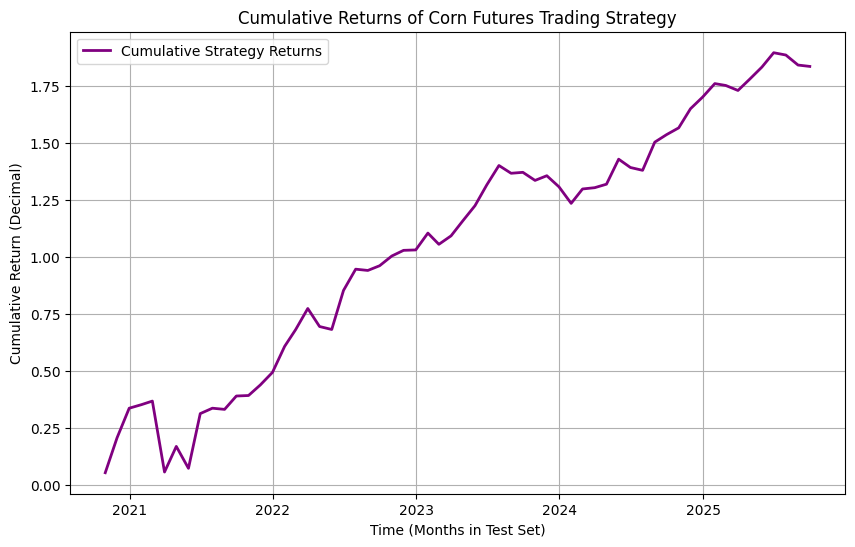

Final Cumulative Return: 1.8373


In [9]:
"""
The Cumulative Returns of the strategy plot...
"""

strategy_ret = data_df[data_df['split'] == 'test']['y_return_next'] * np.sign(proba - 0.5)

plt.figure(figsize=(10, 6))
plt.plot(strategy_ret.cumsum(), label='Cumulative Strategy Returns', color='purple', lw=2)
plt.title('Cumulative Returns of Corn Futures Trading Strategy')
plt.xlabel('Time (Months in Test Set)')
plt.ylabel('Cumulative Return (Decimal)')
plt.legend()
plt.grid(True)
plt.savefig('figures/cumulative_strategy_returns.png')
plt.show()

print(f"Final Cumulative Return: {strategy_ret.cumsum()[-1]:.4f}")

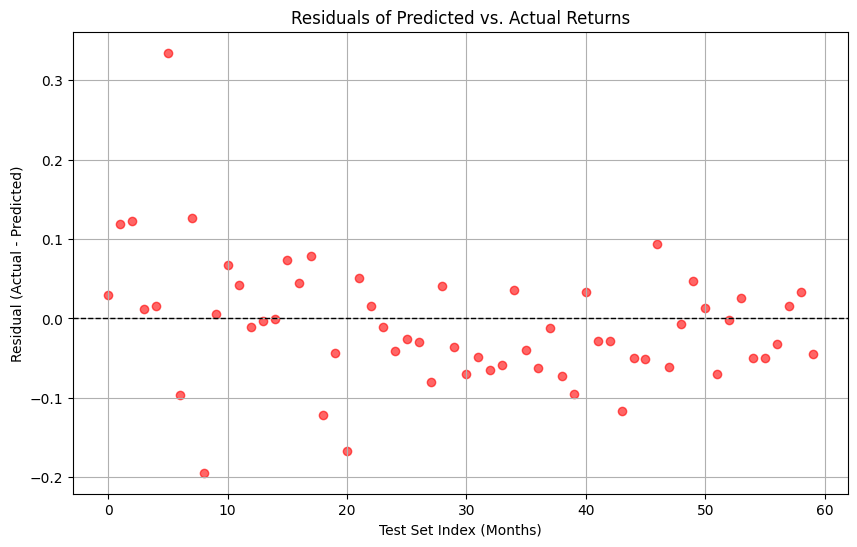

Mean Residual: -0.0084
Residual Standard Deviation: 0.0785


In [10]:
"""
Setting up a Residuals Plot
"""

actual_returns = data_df[data_df['split'] == 'test']['y_return_next'].values
residuals = actual_returns - pred_ret

plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', lw=1)
plt.title('Residuals of Predicted vs. Actual Returns')
plt.xlabel('Test Set Index (Months)')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.savefig('figures/residuals_plot.png')
plt.show()

print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Standard Deviation: {np.std(residuals):.4f}")

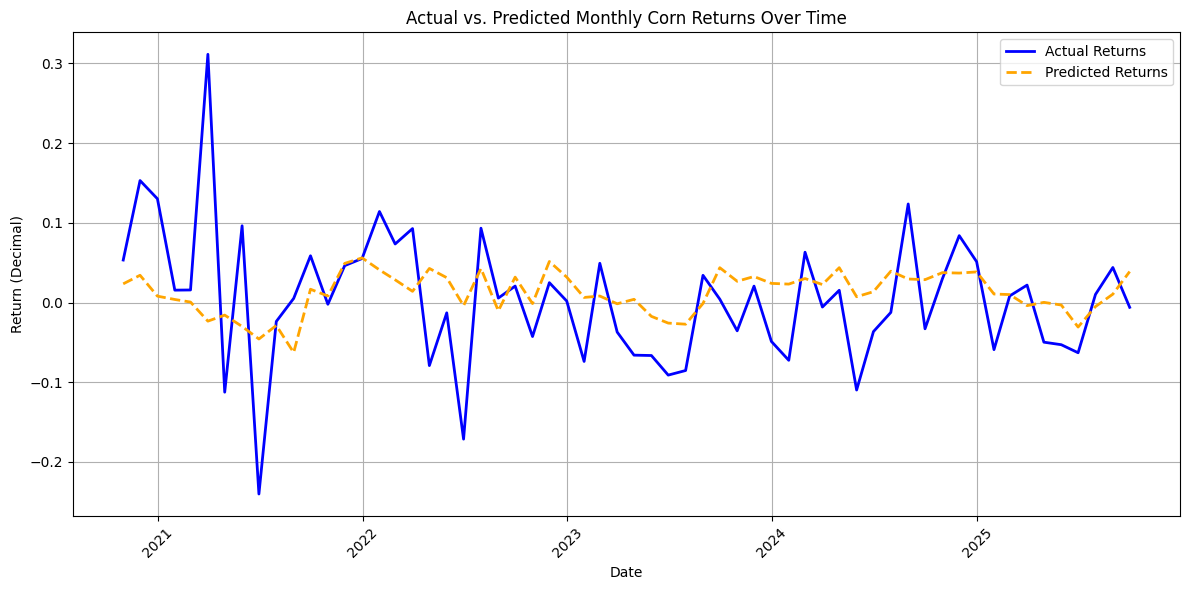

In [ ]:
"""
Setting up the Time Series Plot of Actual vs. Predicted Returns
"""

test_dates = data_df[data_df['split'] == 'test'].index

plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_returns, label='Actual Returns', color='blue', lw=2)
plt.plot(test_dates, pred_ret, label='Predicted Returns', color='orange', lw=2, linestyle='--')
plt.title('Actual vs. Predicted Monthly Corn Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return (Decimal)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/time_series_returns.png')
plt.show()

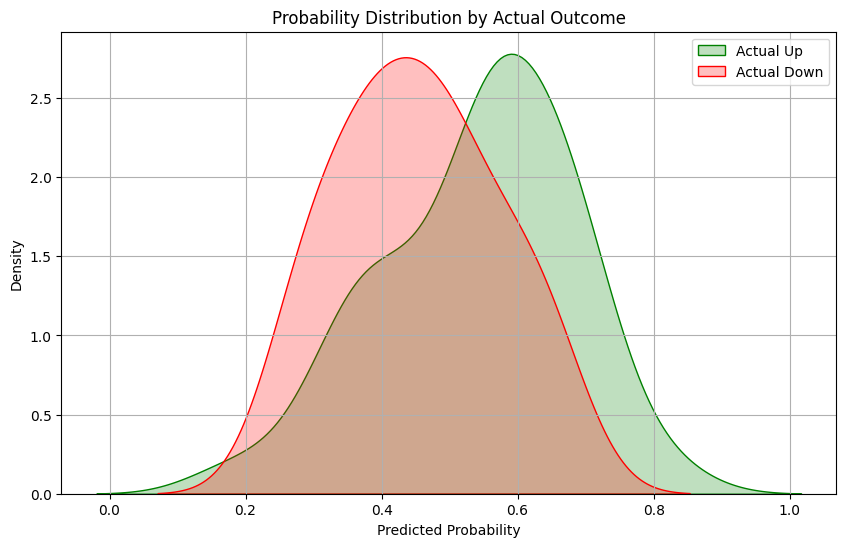

Mean Probability for Up: 0.5402
Mean Probability for Down: 0.4529


In [14]:
"""
Setting up the probability distribution by outcome graph
"""

import seaborn as sns 

up_probs = proba[y_test == 1]  
down_probs = proba[y_test == 0] 

plt.figure(figsize=(10, 6))
sns.kdeplot(up_probs, label='Actual Up', shade=True, color='green')
sns.kdeplot(down_probs, label='Actual Down', shade=True, color='red')
plt.title('Probability Distribution by Actual Outcome')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig('figures/probability_distribution.png')
plt.show()

print(f"Mean Probability for Up: {np.mean(up_probs):.4f}")
print(f"Mean Probability for Down: {np.mean(down_probs):.4f}")